In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.genmod.families.family import Binomial
from statsmodels.tools.tools import add_constant
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def confusion(true, pred, classes):
    """
    Function for pretty printing confusion matrices
    """
    cm = pd.DataFrame(confusion_matrix(true, pred), index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    return cm

data = pd.read_csv("./data/stdHTRU_2.csv")
Class = data['class']
data = data.drop(columns=['class'])
data['Class'] = Class
train, test = train_test_split(data, test_size = 0.1)

print(data)

       Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis  \
0          1.149317       1.334832         -0.669570         -0.400459   
1         -0.334168       1.802265         -0.011785         -0.370535   
2         -0.314372      -1.053322         -0.145233         -0.116593   
3          1.000694       1.553254         -0.513409         -0.390178   
4         -0.871402      -0.858879          0.115609         -0.104866   
...             ...            ...               ...               ...   
17893      0.988208       1.943284         -0.625655         -0.406697   
17894      0.447319       0.429062         -0.328831         -0.234643   
17895      0.321842       1.956220         -0.299334         -0.407492   
17896      0.133628       1.074510         -0.260050         -0.291041   
17897     -2.105762       5.735470          0.872674         -0.272508   

        DM_mean  DM_stdev  DM_skewness  DM_kurtosis  Class  
0     -0.319440 -0.370625    -0.072798    -0.28743

In [90]:
# Fitting a GLM in the learning data in order to 
linear = GLM(train.Class, add_constant(train.loc[:,:data.columns[-2]]), family= Binomial())
lresult = linear.fit()
lresult.summary()

/home/ferja/programs/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:                16108
Model:                            GLM   Df Residuals:                    16099
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1168.8
Date:                Tue, 31 Dec 2019   Deviance:                       2337.6
Time:                        18:08:28   Pearson chi2:                 4.23e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.3870      0.099    -44.526      0.000      -4.580      -4.194
Profile_mean         0.8281      0.161      5.146      0.000       0.513       1.143
Profile_stdev       -0.3014      0.076     -3.978      0.000      -0.450      -0.153
Profile_skewness     6.9916      0.334     20.944      0.000       6.337       7.646
Profile_kurtosis    -3.8139      0.245    -15.570      0.000      -4.294      -3.334
DM_mean             -0.8103      0.110     -7.352      0.000      -1.026      -0.594
DM_stdev             1.0385      0.154      6.722      0.000       0.736       1.341
DM_skewness          0.4938      0.481      1.026      0.305      -0.449       1.437
DM_kurtosis         -0.9114      0.459     -1.986      0.047      -1.811      -0.012
====================================================================================
"""

We see that there are variables that have small weights and maybe are not relevant

In [91]:
# recursive feature elimination (RFE)
logreg =LogisticRegression(solver='liblinear',penalty='l1',C=1)
rfe = RFECV(estimator=logreg,cv=10,n_jobs=-1)
rfe.fit(train.loc[:,:data.columns[-2]],train.Class);

print('Features Selected:',rfe.n_features_)
print('\n Ranking of features')
sel = pd.DataFrame({'features': train.columns[:-1], 'ranking': rfe.ranking_, 'selected':rfe.support_})
sel.sort_values(by='ranking')



Features Selected: 7

 Ranking of features


,features,ranking,selected
0,Profile_mean,1,True
1,Profile_stdev,1,True
2,Profile_skewness,1,True
3,Profile_kurtosis,1,True
4,DM_mean,1,True
5,DM_stdev,1,True
7,DM_kurtosis,1,True
6,DM_skewness,2,False


In [92]:
resultM1 = rfe.estimator_
sel_features = list(sel.features[sel.selected])
sel_features


['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_kurtosis']

All the features are considered relevant, thus all of them are selected

In [93]:
def pulsar_acc(P=0.5):
    # We use predict_proba instead of prediction to obtain
    # the probabilities of the classes and
    # we select only the probability for class 1 as
    # the other is just the complementary

    # Accuracy in training
    pred = resultM1.predict_proba(train.loc[:,sel_features])[:,1]
    lab_tr = [1 if i >= P else 0 for i in pred]
    df_tr = confusion(train.Class,lab_tr, classes=['no_pulsar','pulsar'])
    
    # Accuracy in test
    pred = resultM1.predict_proba(test.loc[:,sel_features])[:,1]
    lab_ts = [1 if i>=P else 0 for i in pred]
    df_ts = confusion(test.Class,lab_ts, classes=['no_pulsar','pulsar'])

    return df_tr, (1-accuracy_score(train.Class,lab_tr))*100, df_ts, (1-accuracy_score(test.Class,lab_ts))*100

c_tr, e_tr, c_ts, e_ts = pulsar_acc()
print(c_tr)
print(f'\nTraining error: {e_tr}% \n')
print(c_ts)
print(f'\nTest error: {e_ts}% \n')


Predicted  no_pulsar  pulsar
Actual                      
no_pulsar      14552      79
pulsar           254    1223

Training error: 2.067295753662779% 

Predicted  no_pulsar  pulsar
Actual                      
no_pulsar       1623       5
pulsar            34     128

Test error: 2.1787709497206653% 



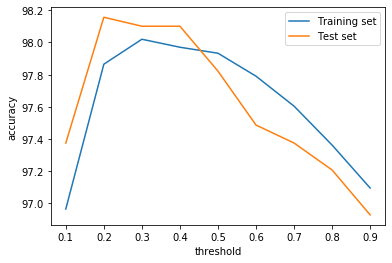

In [94]:
def calculate_accuracy(P, dataset):
    pred = resultM1.predict_proba(dataset.loc[:,sel_features])[:,1]
    lab = [1 if i >= P else 0 for i in pred]

    return accuracy_score(dataset.Class,lab)*100

threshold = list(np.array(range(1,10))/10) # from 0.1 to 0.9

accuracy_tr = list(map(lambda x: calculate_accuracy(x, train), threshold))
accuracy_ts = list(map(lambda x: calculate_accuracy(x, test), threshold))

plt.plot(threshold, accuracy_tr, label='Training set')
plt.plot(threshold, accuracy_ts, label='Test set')

plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend(loc='upper right')
plt.show()

We can see that with our data the threshold with the best accuracy result is 0.3